In [16]:
# !pip install qiskit --quiet
# !pip install qiskit-machine-learning --quiet
# !pip install pylatexenc --quiet

In [17]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline
import sympy as sp

import torch
from torch.utils.data import DataLoader
from torch.nn import Module, Linear, Dropout2d, MaxPool2d, Conv2d
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import cat, no_grad, manual_seed
from torch import optim
from torch.nn import NLLLoss, MSELoss
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn


from qiskit import Aer
from qiskit_machine_learning.neural_networks import OpflowQNN
from qiskit.opflow import AerPauliExpectation
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.circuit import ParameterVector, Parameter, ParameterExpression
from qiskit.utils import QuantumInstance
from qiskit.opflow import StateFn
from qiskit import transpile, assemble
from qiskit.opflow import Z, ListOp,I
import qiskit

In [75]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 16
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.CenterCrop((20,20)),transforms.Resize((8,8))])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

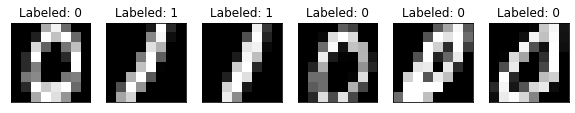

In [76]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [77]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor(),transforms.CenterCrop((20,20)),transforms.Resize((8,8))])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [78]:
# class QConvCircuit:
#     """ 
#     This class provides a simple interface for interaction 
#     with the quantum circuit 
#     """
#     def __init__(self, n_qubits, n_layers, backend, shots):
#         # --- Circuit definition ---
#         self._circuit = qiskit.QuantumCircuit(n_qubits,1)
        
#         all_qubits = [i for i in range(n_qubits)]
#         self.n_qubits = n_qubits
#         self.n_layers = n_layers
#         self.theta = qiskit.circuit.ParameterVector('θ', n_qubits*n_layers)
#         self.theta = np.asarray(self.theta).reshape((n_layers, n_qubits))

#         self._circuit.h(all_qubits)
#         self._circuit.barrier()
        
#         for l in range(n_layers):
#             for q in all_qubits:
#                 self._circuit.ry(self.theta[l][q], q)
            
#             if (l & 1):
#                 for q0, q1 in zip(all_qubits[1::2], all_qubits[2::2] + [all_qubits[0]]):
#                     self._circuit.cz(q0,q1)

#             else:
#                 for q0, q1 in zip(all_qubits[0::2], all_qubits[1::2]):                 
#                     self._circuit.cz(q0,q1)
        
#         self._circuit.measure(-1,0)
#         # ---------------------------

#         self.backend = backend
#         self.shots = shots
    
#     def run(self, thetas):
#         parameter_binds = [{self.theta[l][q]: thetas[l][q] for q in range(self.n_qubits) for l in range(self.n_layers)}]

#         t_qc = transpile(self._circuit,
#                          self.backend)
#         qobj = assemble(t_qc,
#                         shots=self.shots,
#                         parameter_binds = parameter_binds )
#         job = self.backend.run(qobj)
#         result = job.result().get_counts()
        
#         counts = np.array(list(result.values()))
#         states = np.array(list(result.keys())).astype(float)
        
#         # Compute probabilities for each state
#         probabilities = counts / self.shots
#         # Get state expectation
#         expectation = np.sum(states * probabilities)
        
#         return np.array([expectation])

In [79]:
# simulator = qiskit.Aer.get_backend('aer_simulator')

# n_layers = 2
# n_qubits = 4

# thetas = np.ones((n_layers, n_qubits))*np.pi

# circuit = QConvCircuit(n_qubits, n_layers, simulator, 100)
# print('Expected value for rotation pi {}'.format(circuit.run(thetas)[0]))
# circuit._circuit.draw('mpl')

In [91]:
class QConvCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits,1)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.ry(self.theta, all_qubits)
        
        self._circuit.measure(-1,0)
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        batch_dim = thetas.shape[0]
        
        qobjs = [assemble(t_qc,shots=self.shots,parameter_binds=[{self.theta:thetas[i][0].item()}]) for i in range(batch_dim)]
        results = [ self.backend.run(qobj).result().get_counts()  for qobj in qobjs]
        counts = [ np.array(list(result.values())) for result in results]
        states = [ np.array(list(result.keys())).astype(float) for result in results]
        
        # Compute probabilities for each state
        probabilities = [count / self.shots for count in counts]
        # Get state expectation
        expectation = [np.sum(state * probability)  for state, probability in zip(states, probabilities)]
        
        return torch.Tensor(expectation).reshape((batch_dim,1))

Expected value for rotation pi tensor([[0.0000],
        [0.4200]])


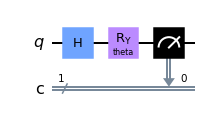

In [92]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QConvCircuit(1, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run(np.array([[-np.pi/2],[np.pi]]))))
circuit._circuit.draw('mpl')

In [123]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, w, b, x, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        
        z1 = torch.mm(x, w.t())
        z1 = torch.add(z1, b)
        z2 = (np.pi/2)*torch.tanh(z1)
        
        a = ctx.quantum_circuit.run(z2)
        ctx.save_for_backward(w, b, x, a,z1,z2)

        return a
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        w,b,x, a, z1,z2 = ctx.saved_tensors
        batch_size = x.shape[0]
        
        z2_shift_right = z2 + torch.ones(z2.shape[1]) * ctx.shift
        z2_shift_left = z2 - torch.ones(z2.shape[1]) * ctx.shift
        
        z2_expectation_right = ctx.quantum_circuit.run(z2_shift_right)
        z2_expectation_left = ctx.quantum_circuit.run(z2_shift_left)
        
        f_grad = (z2_expectation_right - z2_expectation_left)/2
        
        dz2 = grad_output*f_grad
        
        dz1 = dz2*(np.pi/2)*(1 - (torch.tanh(z1)**2))
        
        dw = dz1*torch.mean(x, 0).reshape((1,-1))
        
        dw = (dz1.t()@x)/batch_size

        db = torch.mean(dz1).reshape((1))
        
        dx = dz1 @ dw
    
        return dw, db, dx, None,None

In [124]:
class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, n_inputs, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QConvCircuit(1, backend, shots)
        self.shift = shift
        
        self.weights = nn.Parameter(torch.Tensor(1,n_inputs))
        self.bias = nn.Parameter(torch.Tensor(1))
        
        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=np.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / np.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init
        
    def forward(self, input):
        return HybridFunction.apply(self.weights, self.bias, input, self.quantum_circuit, self.shift)

In [125]:
class Net(nn.Module):
    def __init__(self, kernel_size=(3,3), strides=(2,2)):
        super(Net, self).__init__()
        
        n_inputs = np.prod(kernel_size)
        self.hybrid = Hybrid(n_inputs, qiskit.Aer.get_backend('aer_simulator'), 1000, np.pi / 8)
        self.hybrid2 = Hybrid(9, qiskit.Aer.get_backend('aer_simulator'), 1000, np.pi / 8)
        
        self.kernel_size = kernel_size
        self.strides = strides

    def forward(self, x):
        
        k = self.kernel_size
        s = self.strides
        
        iter_x = int((x.shape[2] - k[0]) / s[0] + 1)
        iter_y = int((x.shape[3] - k[1]) / s[1] + 1)
        
        out = []
        for i in range(iter_x):
            for j in range(iter_y):
                _x = x[:,0, i*s[0]:i*s[0] + k[0], j*s[1]:j*s[1] + k[1]]
                _x = _x.flatten(start_dim = 1)
                out+= [self.hybrid(_x)]
        out = torch.cat(out,-1)
        out = torch.reshape(out,(-1,1, iter_x,iter_y))
        out = out.flatten(start_dim = 1)
        x = self.hybrid2(out)
        return torch.cat((x, 1 - x), -1)

In [126]:
model = Net()

In [127]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [128]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-8)
loss_func = NLLLoss()

# Start training
epochs = 5  # Set number of epochs
history = []  # Store history
model.train()  # Set model to training mode

for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model(data)  # Forward pass
        acc = accuracy(output, target)
        loss = loss_func(output, target)  # Calculate loss
        history.append({'loss':loss.item(), 'acc':acc}) # Store training loss and acc
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights 
        print(history[-1])
    print("Training [{:.0f}%]\tLoss: {}".format(100.0 * (epoch + 1) / epochs, history[-1]))

{'loss': -0.40049999952316284, 'acc': tensor(0.3125)}
{'loss': -0.4573124945163727, 'acc': tensor(0.4375)}
{'loss': -0.539312481880188, 'acc': tensor(0.6250)}
{'loss': -0.4593750238418579, 'acc': tensor(0.4375)}
{'loss': -0.5439375042915344, 'acc': tensor(0.6250)}
{'loss': -0.5235000252723694, 'acc': tensor(0.5625)}
{'loss': -0.3695625066757202, 'acc': tensor(0.2500)}
{'loss': -0.4818125069141388, 'acc': tensor(0.5000)}
{'loss': -0.4829999804496765, 'acc': tensor(0.5000)}
{'loss': -0.4363749921321869, 'acc': tensor(0.3750)}
{'loss': -0.5163750052452087, 'acc': tensor(0.5625)}
{'loss': -0.5833125114440918, 'acc': tensor(0.6875)}
{'loss': -0.6128749847412109, 'acc': tensor(0.7500)}
Training [20%]	Loss: {'loss': -0.6128749847412109, 'acc': tensor(0.7500)}
{'loss': -0.432250052690506, 'acc': tensor(0.3750)}
{'loss': -0.43293750286102295, 'acc': tensor(0.3750)}
{'loss': -0.45912498235702515, 'acc': tensor(0.4375)}
{'loss': -0.5698124766349792, 'acc': tensor(0.6875)}
{'loss': -0.487250000238

In [ ]:
# Plot loss convergence
loss_list = [x['loss'] for x in history]
plt.plot(loss_list)
plt.title("Hybrid NN Training Loss Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [ ]:
acc_list = [x['acc'] for x in history]
plt.plot(acc_list)
plt.title("Hybrid NN Training Acc")
plt.xlabel("Training Iterations")
plt.ylabel("Acc")
plt.show()

In [ ]:
torch.save(model.state_dict(), "model.pt")


In [ ]:
observables = ListOp([Z])
operator, _ = create_qcnn(4,observables)
model = Net(operator)
model.load_state_dict(torch.load("model.pt"))

In [ ]:
model.eval()  # set model to evaluation mode
total_loss = []
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

In [ ]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1
